In [1]:
import sys  
sys.path.insert(0, '..')

from datetime import date, timedelta

from config import Config

import pandas as pd
from sqlalchemy import create_engine

import matplotlib

db = create_engine(Config.SQLALCHEMY_DATABASE_URI)

In [131]:
ockovani = pd.read_sql_query(
    """
    select datum, vekova_skupina, sum(pocet) pocet_ockovani
    from ockovani_lide o
    join vakciny v on (o.vakcina = v.vakcina)
    where poradi_davky = v.davky
    group by datum, vekova_skupina
    order by datum
    """,
    db
)
ockovani['pocet_ockovani'] = ockovani.groupby('vekova_skupina')['pocet_ockovani'].transform(pd.Series.cumsum)
ockovani

,datum,vekova_skupina,pocet_ockovani
0,2021-01-10,45-49,1
1,2021-01-10,60-64,1
2,2021-01-11,18-24,1
3,2021-01-11,25-29,1
4,2021-01-12,55-59,1
...,...,...,...
3405,2021-09-18,60-64,462391
3406,2021-09-18,65-69,536354
3407,2021-09-18,70-74,523304
3408,2021-09-18,75-79,358878


In [2]:
populace = pd.read_sql_query(
    """
    select vekova_skupina, sum(pocet) pocet_populace from populace_kategorie k 
    join populace p on (p.vek >= k.min_vek AND p.vek <= k.max_vek)
    where orp_kod='CZ0'
    group by vekova_skupina
    order by vekova_skupina
    """,
    db
)
populace

,vekova_skupina,pocet_populace
0,0-11,1367105.0
1,12-15,456488.0
2,16-17,195016.0
3,18-24,669492.0
4,25-29,620925.0
5,30-34,718931.0
6,35-39,753310.0
7,40-44,893321.0
8,45-49,882586.0
9,50-54,691083.0


In [113]:
nakazeni = pd.read_sql_query(
    """
    select datum, vekova_skupina, sum(pocet) pocet_nakazeni from nakazeni
    where vekova_skupina != '-'
    group by datum, vekova_skupina
    order by datum
    """,
    db
)
nakazeni = nakazeni.groupby(['vekova_skupina', 'datum']).sum().rolling(7).sum().divide(7)
nakazeni

pocet_nakazeni
vekova_skupina datum                     
0-17           2020-03-06             NaN
               2020-03-09             NaN
               2020-03-10             NaN
               2020-03-11             NaN
               2020-03-12             NaN
...                                   ...
80+            2021-09-14        5.571429
               2021-09-15        6.000000
               2021-09-16        5.571429
               2021-09-17        5.428571
               2021-09-18        5.142857

[7622 rows x 1 columns]

In [176]:
df = pd.merge(nakazeni, ockovani, how='outer', on=['datum', 'vekova_skupina'])
df = pd.merge(df, populace, how='outer', on='vekova_skupina')
df = df.fillna(0)
df['nakazeni_100k'] = df['pocet_nakazeni'] * 100000 / df['pocet_populace']
df['ockovani_100k'] = df['pocet_ockovani'] * 100000 / df['pocet_populace']
df['nakazeni_100k_neockovani'] = df['pocet_nakazeni'] * 100000 / (df['pocet_populace'] - df['pocet_ockovani'])
df = df.fillna(0)
df = df.reset_index()
df

,index,datum,vekova_skupina,pocet_nakazeni,pocet_ockovani,pocet_populace,nakazeni_100k,ockovani_100k,nakazeni_100k_neockovani
0,0,2020-03-06,0-17,0.0,0.0,2018609.0,0.0,0.000000,0.0
1,1,2020-03-09,0-17,0.0,0.0,2018609.0,0.0,0.000000,0.0
2,2,2020-03-10,0-17,0.0,0.0,2018609.0,0.0,0.000000,0.0
3,3,2020-03-11,0-17,0.0,0.0,2018609.0,0.0,0.000000,0.0
4,4,2020-03-12,0-17,0.0,0.0,2018609.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...
7710,7710,2021-08-14,80+,0.0,355084.0,447526.0,0.0,79343.769971,0.0
7711,7711,2021-08-15,80+,0.0,355127.0,447526.0,0.0,79353.378351,0.0
7712,7712,2021-08-19,80+,0.0,356412.0,447526.0,0.0,79640.512507,0.0
7713,7713,2021-08-29,80+,0.0,358261.0,447526.0,0.0,80053.672859,0.0


In [201]:
grp1 = '80+'
grp2 = '70-74'

<AxesSubplot:>

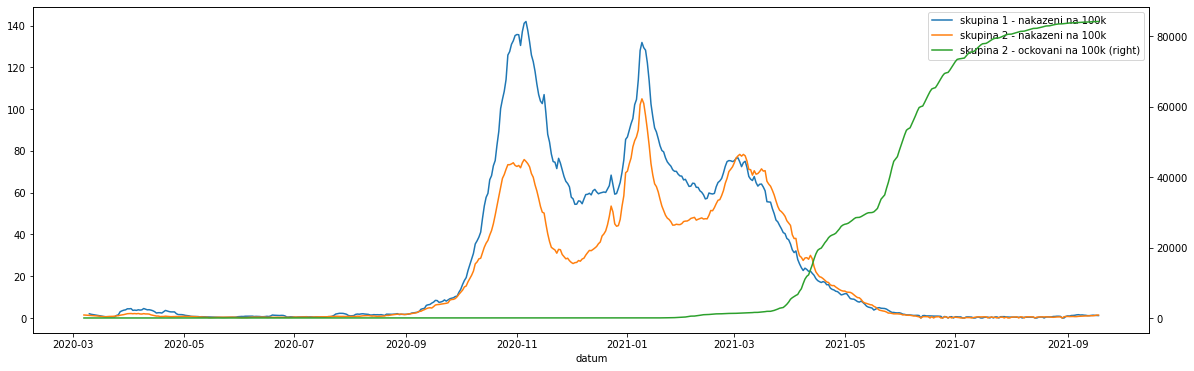

In [202]:
df_grp_1 = df[df['vekova_skupina'] == grp1]
df_grp_2 = df[df['vekova_skupina'] == grp2]

ax = df_grp_1.plot(x='datum', y='nakazeni_100k', label='skupina 1 - nakazeni na 100k', figsize=(20, 6))
# df_grp_1.plot(x='datum', y='ockovani_100k', label='skupina 1 - ockovani na 100k', secondary_y=True, ax=ax)

df_grp_2.plot(x='datum', y='nakazeni_100k', label='skupina 2 - nakazeni na 100k', ax=ax)
df_grp_2.plot(x='datum', y='ockovani_100k', label='skupina 2 - ockovani na 100k', secondary_y=True, ax=ax)

<AxesSubplot:xlabel='datum'>

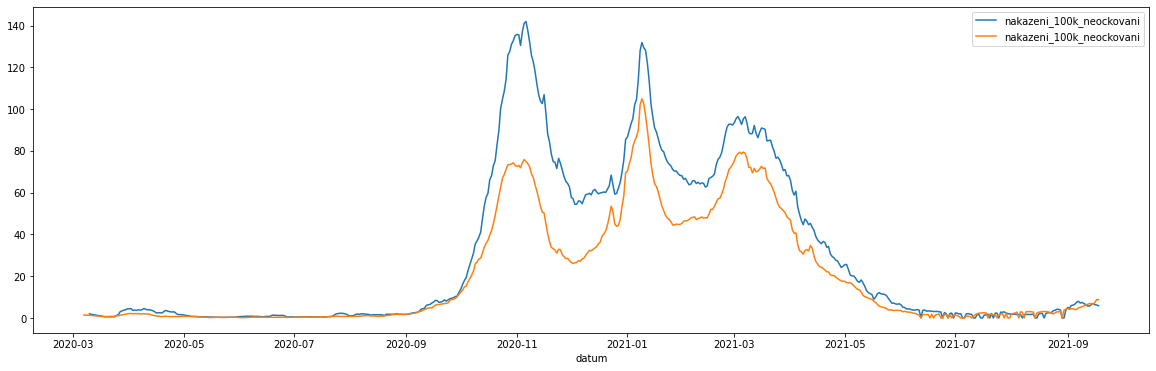

In [203]:
ax1 = df[df['vekova_skupina'] == grp1].plot(x='datum', y='nakazeni_100k_neockovani', figsize=(20, 6))
df[df['vekova_skupina'] == grp2].plot(x='datum', y='nakazeni_100k_neockovani', figsize=(20, 6), ax=ax1)

In [4]:
nakazeni_v = pd.read_sql_query(
    """
    select * from nakazeni_ockovani n 
    """,
    db
)
nakazeni_v

,datum,celkem,bez_ockovani,bez_ockovani_vek_prumer,nedokoncene_ockovani,nedokoncene_ockovani_vek_prumer,dokoncene_ockovani,dokoncene_ockovani_vek_prumer,posilujici_davka,posilujici_davka_vek_prumer
0,2021-01-01,3447,3433,45,14,43,0,0,0,0
1,2021-01-02,4987,4974,46,13,42,0,0,0,0
2,2021-01-03,6269,6252,44,17,51,0,0,0,0
3,2021-01-04,12964,12937,45,27,45,0,0,0,0
4,2021-01-05,17408,17370,44,38,46,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
283,2021-10-11,1341,1010,27,15,36,316,50,0,0
284,2021-10-12,1509,1138,28,11,37,360,48,0,0
285,2021-10-13,1499,1126,27,12,41,361,50,0,0
286,2021-10-14,1534,1145,27,14,26,375,50,0,0


In [18]:
ockovani_v = pd.read_sql_query(
    """
    select datum, sum(o.pocet) pocet_ockovani, (select sum(pocet) from populace where orp_kod = 'CZ0') pocet_celkem
    from ockovani_lide o
    join vakciny v on (o.vakcina = v.vakcina)
    where poradi_davky = v.davky
    group by datum
    order by datum
    """,
    db
)
ockovani_v['pocet_ockovani'] = ockovani_v['pocet_ockovani'].transform(pd.Series.cumsum)
ockovani_v['pocet_neockovani'] = ockovani_v['pocet_celkem'] - ockovani_v['pocet_ockovani']
ockovani_v

,datum,pocet_ockovani,pocet_celkem,pocet_neockovani
0,2021-01-09,1,10701777.0,10701776.0
1,2021-01-10,3,10701777.0,10701774.0
2,2021-01-11,5,10701777.0,10701772.0
3,2021-01-12,7,10701777.0,10701770.0
4,2021-01-14,9,10701777.0,10701768.0
...,...,...,...,...
271,2021-10-09,6001746,10701777.0,4700031.0
272,2021-10-10,6002571,10701777.0,4699206.0
273,2021-10-11,6006841,10701777.0,4694936.0
274,2021-10-12,6010545,10701777.0,4691232.0


In [21]:
merged = pd.merge(nakazeni_v, ockovani_v)

In [25]:
pd.set_option('display.max_rows', 500)

In [26]:
merged['bez_100k'] = 100000 * merged['bez_ockovani'] / merged['pocet_neockovani']
merged['s_100k'] = 100000 * merged['dokoncene_ockovani'] / merged['pocet_ockovani']
merged['diff'] = merged['bez_100k'] / merged['s_100k']
merged

,datum,celkem,bez_ockovani,bez_ockovani_vek_prumer,nedokoncene_ockovani,nedokoncene_ockovani_vek_prumer,dokoncene_ockovani,dokoncene_ockovani_vek_prumer,posilujici_davka,posilujici_davka_vek_prumer,pocet_ockovani,pocet_celkem,pocet_neockovani,bez_100k,s_100k,diff
0,2021-01-09,8444,8416,44,28,48,0,0,0,0,1,10701777.0,10701776.0,78.641153,0.000000,inf
1,2021-01-10,4314,4283,43,31,45,0,0,0,0,3,10701777.0,10701774.0,40.021402,0.000000,inf
2,2021-01-11,9386,9288,44,98,48,0,0,0,0,5,10701777.0,10701772.0,86.789365,0.000000,inf
3,2021-01-12,10814,10710,44,104,51,0,0,0,0,7,10701777.0,10701770.0,100.076903,0.000000,inf
4,2021-01-14,8108,8009,44,99,47,0,0,0,0,9,10701777.0,10701768.0,74.838102,0.000000,inf
5,2021-01-16,5243,5166,42,77,53,0,0,0,0,12,10701777.0,10701765.0,48.272411,0.000000,inf
6,2021-01-17,2644,2605,43,39,53,0,0,0,0,650,10701777.0,10701127.0,24.343230,0.000000,inf
7,2021-01-18,7677,7469,43,208,53,0,0,0,0,2472,10701777.0,10699305.0,69.808273,0.000000,inf
8,2021-01-19,9617,9433,43,184,51,0,0,0,0,5192,10701777.0,10696585.0,88.187024,0.000000,inf
9,2021-01-20,8225,8061,44,164,54,0,0,0,0,7840,10701777.0,10693937.0,75.379161,0.000000,inf
